In [1]:
import math
import time
import os
import json

import torch as T
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [2]:
from motion_capture.model.models import UpsampleCrossAttentionNetwork, find_best_checkpoint_path
from motion_capture.data.datasets import WFLWFaceDetection

checkpoint_pth = find_best_checkpoint_path("checkpoints/bboxBackbone/UpsampleAtt-WFLW")
network = UpsampleCrossAttentionNetwork.load_from_checkpoint(checkpoint_pth).to("cpu").eval()
dataset = WFLWFaceDetection(
    image_shape_WH=(224, 224),
    path="//192.168.2.206/data/datasets/WFLW",
    max_number_of_faces=network.hparams.output_length
)

found best model with loss: 0.19416305422782898 from C:\Users\noone\Documents\programming\motion-capture\checkpoints\bboxBackbone\UpsampleAtt-WFLW\epoch=33-step=1734-val_loss=0.1942.ckpt


tested loss: 54.51250076293945
sanity check loss: tensor([[14.6719, 22.7031,  2.2422,  2.5172,  2.3672,  2.3172,  2.0172,  1.8672,
          1.8922,  1.9172]])


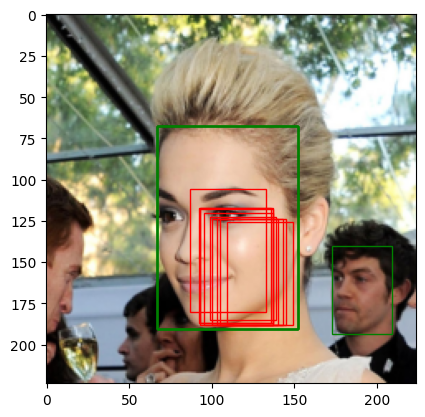

: 

In [4]:
test_i = 0
test_dp = dataset[test_i]

y_ = network(test_dp[0].unsqueeze(0) / 255)[0]
y_ = (y_ * 224).to(T.int)

plt.imshow(test_dp[0].permute(1, 2, 0).to(T.uint8))

for bbox in test_dp[1]:
    x, y = bbox[:2]
    w, h = bbox[2:]
    plt.gca().add_patch(patches.Rectangle(
        (x - w, y - h),
        w * 2, h * 2,
        linewidth=1,
        edgecolor="g",
        facecolor="none"
    ))

for bbox in y_:
    x, y = bbox[:2]
    w, h = bbox[2:]
    plt.gca().add_patch(patches.Rectangle(
        (x - w, y - h),
        w * 2, h * 2,
        linewidth=1,
        edgecolor="r",
        facecolor="none"
    ))

# print(y_)
# print(test_dp[1])
# print(test_dp[2])

# compute loss
tested_loss = network.compute_loss(y_.unsqueeze(0), test_dp[1].unsqueeze(0), test_dp[2].unsqueeze(0))
print(f"tested loss: {tested_loss}")

# calculate loss for sanity check
loss = nn.functional.l1_loss(y_.unsqueeze(0), test_dp[1].unsqueeze(0), reduction="none")
valid_loss = loss.mean(-1) * test_dp[2].unsqueeze(0)
invalid_loss = loss.mean(-1) * (1 - test_dp[2].unsqueeze(0)) * 0.1
loss = valid_loss + invalid_loss
print(f"sanity check loss: {loss}")

## PyTorch Pretrained Models Speedtest

In [1]:
from torchvision import models as torchModels
from motion_capture.model import models as mocapModels
import torch as T

In [6]:
object_detection_models = {
    "fcos_resnet50_fpn": torchModels.detection.fcos_resnet50_fpn(weights=torchModels.detection.FCOS_ResNet50_FPN_Weights.COCO_V1),
    "fasterrcnn_mobilenet_v3_large_320_fpn": torchModels.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=torchModels.detection.FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1),
    "fasterrcnn_mobilenet_v3_large_fpn": torchModels.detection.fasterrcnn_mobilenet_v3_large_fpn(weights=torchModels.detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1),
    "fasterrcnn_resnet50_fpn_v2": torchModels.detection.fasterrcnn_resnet50_fpn_v2(weights=torchModels.detection.FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1),
    "fasterrcnn_resnet50_fpn": torchModels.detection.fasterrcnn_resnet50_fpn(weights=torchModels.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1),
    "retinanet_resnet50_fpn_v2": torchModels.detection.retinanet_resnet50_fpn_v2(weights=torchModels.detection.RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1),
    "retinanet_resnet50_fpn": torchModels.detection.retinanet_resnet50_fpn(weights=torchModels.detection.RetinaNet_ResNet50_FPN_Weights.COCO_V1),
    "ssd300_vgg16": torchModels.detection.ssd300_vgg16(weights=torchModels.detection.SSD300_VGG16_Weights.COCO_V1),
    "ssdlite320_mobilenet_v3_large": torchModels.detection.ssdlite320_mobilenet_v3_large(weights=torchModels.detection.SSDLite320_MobileNet_V3_Large_Weights.COCO_V1),
}

In [8]:
from motion_capture.core import benchmark
from torchvision import models as torchModels
from motion_capture.model import heads
import torch as T

net = torchModels.convnext_tiny().features
head = heads.AttentionHead(768, 4, 10, 1024, 3)

benchmark.model_speedtest(net, (1, 3, 224, 224), ntests=100)
benchmark.model_speedtest(head, (1, 768, 7, 7), ntests=100)

model_ = T.nn.Sequential(net, head)
benchmark.model_speedtest(model_, (1, 3, 224, 224), ntests=100)

speedtest engaged for <class 'torch.nn.modules.container.Sequential'>
	# parameters: 27.818592071533203 M
	fps: 154.19002131582877
speedtest engaged for <class 'motion_capture.model.heads.AttentionHead'>
	# parameters: 30.9483699798584 M
	fps: 356.7198892714864
speedtest engaged for <class 'torch.nn.modules.container.Sequential'>
	# parameters: 58.76696014404297 M
	fps: 126.41451521826477


In [4]:
backbone_models = [
    # "deeplabv3_mobilenet_v3_large",
    # "deeplabv3_resnet101",
    # "deeplabv3_resnet50",
    "fasterrcnn_mobilenet_v3_large_320_fpn",
    "fasterrcnn_mobilenet_v3_large_fpn",
    "fasterrcnn_resnet50_fpn",
    "fasterrcnn_resnet50_fpn_v2",
    # "fcn_resnet101",
    # "fcn_resnet50",
    "fcos_resnet50_fpn",
    "keypointrcnn_resnet50_fpn",
    # "lraspp_mobilenet_v3_large",
    "maskrcnn_resnet50_fpn",
    "maskrcnn_resnet50_fpn_v2",
    "retinanet_resnet50_fpn",
    "retinanet_resnet50_fpn_v2",
]

In [8]:
from motion_capture.core import benchmark

for model in backbone_models:
    print(f"benchmarking {model}")
    model = torchModels.get_model(model).backbone
    benchmark.model_speedtest(model, (1, 3, 224, 224), ntests=100)

NameError: name 'backbone_models' is not defined

In [7]:
for model in backbone_models:
    backbone_out = torchModels.get_model(model).backbone(T.randn(1, 3, 448, 448))
    last_3_shapes = [backbone_out[a].shape for a in list(backbone_out)[-3:]]
    print(f"model: {model}: {last_3_shapes}")

NameError: name 'backbone_models' is not defined

In [10]:
uca = mocapModels.UpsampleCrossAttentionNetwork(
    backbone=object_detection_models["fasterrcnn_mobilenet_v3_large_320_fpn"].backbone,
    neck=mocapModels.UpsampleCrossAttentionrNeck(128, 256, 1),
    heads={
        "bboxes": mocapModels.SelfAttentionHead(128, 4, 10, 256)
    }
)

backbone_out = uca.backbone(T.randn(1, 3, 224, 224))
print([v.shape for v in list(backbone_out.values())])

[torch.Size([1, 256, 7, 7]), torch.Size([1, 256, 7, 7]), torch.Size([1, 256, 4, 4])]


In [18]:
segmentation_models = {
    "fcn_resnet50": models.segmentation.fcn_resnet50(weights=models.segmentation.FCN_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1),
    "fcn_resnet101": models.segmentation.fcn_resnet101(weights=models.segmentation.FCN_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1),
    "deeplabv3_resnet50": models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1),
    "deeplabv3_resnet101": models.segmentation.deeplabv3_resnet101(weights=models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1),
    "deeplabv3_mobilenet_v3_large": models.segmentation.deeplabv3_mobilenet_v3_large(weights=models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1),
    "lraspp_mobilenet_v3_large": models.segmentation.lraspp_mobilenet_v3_large(weights=models.segmentation.LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1),
}

instance_segmentation_models = {
    "maskrcnn_resnet50_fpn": models.detection.maskrcnn_resnet50_fpn(weights=models.detection.MaskRCNN_ResNet50_FPN_Weights.COCO_V1),
    "maskrcnn_resnet50_fpn_v2": models.detection.maskrcnn_resnet50_fpn_v2(weights=models.detection.MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1),
}

keypoint_detection_models = {
    "keypointrcnn_resnet50_fpn": models.detection.keypointrcnn_resnet50_fpn(weights=models.detection.KeypointRCNN_ResNet50_FPN_Weights.COCO_V1),
}

## Facer